# 1. Libraries

In [1]:
# Visualizations will be shown in the notebook.
%matplotlib inline
import tensorflow
import keras
import cv2 

import pandas as pd
import numpy as np

from matplotlib                  import pyplot as plt
from PIL                         import Image
from sklearn.model_selection     import train_test_split
from sklearn.metrics             import mean_squared_error
from keras.models                import Sequential
from keras.layers.core           import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional  import Convolution2D
from keras.layers.pooling        import MaxPooling2D
from keras.preprocessing.image   import ImageDataGenerator
from keras.callbacks             import ModelCheckpoint
from keras                       import backend as K

from tensorflow.keras                           import optimizers
from tensorflow.keras.layers                    import BatchNormalization
from tensorflow.keras.applications              import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3

# 2. Data Analyst

## 2.1 Get data

In [2]:
all_path  = '../input/data-driving-car/all'
all1_path = '../input/data-driving-car/all1'
all2_path = '../input/data-driving-car/all2'

recover1_path = '../input/data-driving-car/sub/recover1'
recover2_path = '../input/data-driving-car/sub/recover2'
track1_path   = '../input/data-driving-car/sub/track1'
track2_path   = '../input/data-driving-car/sub/track2'
udacity1_path = "../input/data-driving-car/sub/udacity1"

img_path      = all_path + '/IMG/'

In [3]:
all_csv      = pd.read_csv(all_path      + '/driving_log.csv')
all1_csv     = pd.read_csv(all1_path     + '/driving_log.csv')
all2_csv     = pd.read_csv(all2_path     + '/driving_log.csv')
recover1_csv = pd.read_csv(recover1_path + '/driving_log.csv')
recover2_csv = pd.read_csv(recover2_path + '/driving_log.csv')
track1_csv   = pd.read_csv(track1_path   + '/driving_log.csv')
track2_csv   = pd.read_csv(track2_path   + '/driving_log.csv')
udacity1_csv = pd.read_csv(udacity1_path + '/driving_log.csv')

print("All   dataset has {0} rows".format(len(all_csv)))
print("All 1 dataset has {0} rows".format(len(all1_csv)))
print("All 2 dataset has {0} rows".format(len(all2_csv)))

All   dataset has 42400 rows
All 1 dataset has 20808 rows
All 2 dataset has 21592 rows


In [4]:
def get_steering_angles(data, st_column, st_calibrations, filtering_f=None):
    cols = len(st_calibrations)
    print("CALIBRATIONS={0}, ROWS={1}".format(cols, data.shape[0]))
    angles = np.zeros(data.shape[0] * cols, dtype=np.float32)  
    i = 0
    for indx, row in data.iterrows():        
        st_angle = row[st_column]
        for (j,st_calib) in enumerate(st_calibrations):  
            angles[i * cols + j] = st_angle + st_calib
        i += 1
    return np.clip(angles, -1, 1)

all_st_angles_without_calibrations  = get_steering_angles(all_csv , "steering", [0])
all1_st_angles_without_calibrations = get_steering_angles(all1_csv, "steering", [0])
all2_st_angles_without_calibrations = get_steering_angles(all2_csv, "steering", [0])

CALIBRATIONS=1, ROWS=42400


CALIBRATIONS=1, ROWS=20808


CALIBRATIONS=1, ROWS=21592


In [5]:
def read_img(img_full_path, img_dir="/IMG"):
    prefix_path = all_path + img_dir   
    img_path = "{0}/{1}".format(prefix_path, img_full_path.split("\\")[-1])    
    img = cv2.imread(img_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## 2.2 Split data Train/Validation/Test (50/10/40)

In [6]:
train_samples, tmp_samples       = train_test_split(all_csv    , test_size = 0.5, random_state=4)
validation_samples, test_samples = train_test_split(tmp_samples, test_size = 0.8, random_state=4)

print("The size of train      dataset:",len(train_samples     ))
print("The size of validation dataset:",len(validation_samples))
print("The size of test       dataset:",len(test_samples      ))

The size of train      dataset: 21200
The size of validation dataset: 4240
The size of test       dataset: 16960


# 3. Visualize Data

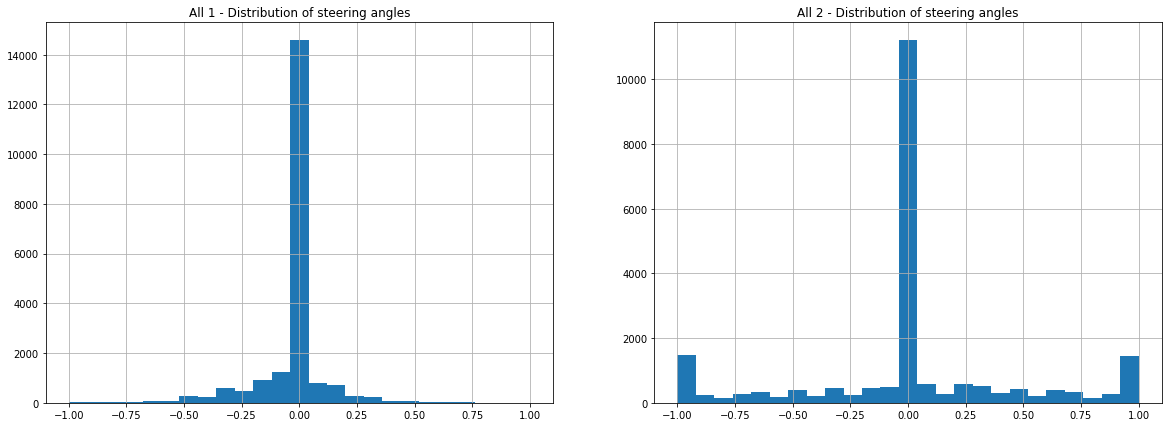

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].grid(True)
ax[0].set(title="All 1 - Distribution of steering angles")
count, bins, _ = ax[0].hist(all1_st_angles_without_calibrations, bins=25,histtype='bar' )

ax[1].grid(True)
ax[1].set(title="All 2 - Distribution of steering angles")
count, bins, _ = ax[1].hist(all2_st_angles_without_calibrations, bins=25,histtype='bar' )

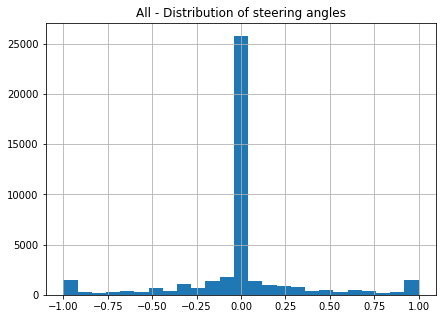

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.grid(True)
ax.set(title="All - Distribution of steering angles")
count, bins, _ = ax.hist(all_st_angles_without_calibrations, bins=25, histtype='bar')

# 4. Data Agument

In [9]:
def fliph_image(img):
    return cv2.flip(img, 1)

def blur_image(img, f_size=5):
    img = cv2.GaussianBlur(img,(f_size, f_size),0)
    img = np.clip(img, 0, 255)
    return img.astype(np.uint8) 

def change_image_brightness_rgb(img, s_low=0.2, s_high=0.75):
    img = img.astype(np.float32)
    s = np.random.uniform(s_low, s_high)
    img[:,:,:] *= s
    np.clip(img, 0, 255)
    return  img.astype(np.uint8)

def translate_image(img, st_angle, low_x_range, high_x_range, low_y_range, high_y_range, delta_st_angle_per_px):
    rows, cols = (img.shape[0], img.shape[1])
    translation_x = np.random.randint(low_x_range, high_x_range) 
    translation_y = np.random.randint(low_y_range, high_y_range) 
    st_angle += translation_x * delta_st_angle_per_px
    translation_matrix = np.float32([[1, 0, translation_x],[0, 1, translation_y]])
    img = cv2.warpAffine(img, translation_matrix, (cols, rows))
    return img, st_angle 

In [10]:
def augment_image(img, st_angle):
    aug_img = img
    
    if np.random.random_sample() <= 0.5:
        aug_img = blur_image(aug_img)
    if np.random.random_sample() <= 0.5:
        aug_img = fliph_image(aug_img)
        st_angle = - st_angle
    if np.random.random_sample() <= 0.5:       
        aug_img = change_image_brightness_rgb(aug_img)       
    if np.random.random_sample() <= 0.5:
        aug_img, st_angle = translate_image(aug_img, st_angle, -60, 61, -20, 21, 0.35/100.0)

    return aug_img, st_angle

# 5. Generator

In [11]:
def generate_images(df, target_dimensions, img_types, st_column, st_angle_calibrations, 
                    batch_size=100, shuffle=True, data_aug_pct=0.8, aug_likelihood=0.5, 
                    st_angle_threshold=0.05, neutral_drop_pct=0.25):

    # e.g. 160x320x3 for target_dimensions
    batch = np.zeros((batch_size, target_dimensions[0],  target_dimensions[1],  target_dimensions[2]), dtype=np.float32)
    steering_angles = np.zeros(batch_size)
    df_len = len(df)
    
    while True:
        k = 0
        while k < batch_size:            
            idx = np.random.randint(0, df_len)       
            for img_t, st_calib in zip(img_types, st_angle_calibrations):
                if k >= batch_size:
                    break
                                
                row = df.iloc[idx]
                st_angle = row[st_column]            
                
                # Drop neutral-ish steering angle images with some probability
                if abs(st_angle) < st_angle_threshold and np.random.random_sample() <= neutral_drop_pct :
                    continue
                    
                st_angle += st_calib                                                                
                img_type_path = row[img_t]  
                img = read_img(img_type_path)                
                
                # Resize image            
                img, st_angle = augment_image(img, st_angle) if np.random.random_sample() <= data_aug_pct else (img, st_angle)
                batch[k] = img
                steering_angles[k] = st_angle
                k += 1
            
        yield batch, np.clip(steering_angles, -1, 1)    

In [12]:
batch_size = 32
st_angle_names = ["center", "left", "right"]
st_angle_calibrations = [0, 0.25, -0.25]

train_generator      = generate_images(train_samples,      (160, 320, 3), st_angle_names, "steering", st_angle_calibrations,  batch_size=batch_size)
validation_generator = generate_images(validation_samples, (160, 320, 3), st_angle_names, "steering", st_angle_calibrations,  batch_size=batch_size, data_aug_pct=0.0)

# 6. Model

## 6.1 NVIDIA Model

In [13]:
def nvidia_model(optimizer, activation):
    model = Sequential()

    model.add(Lambda(lambda imgs: imgs[:,80:,:,:], input_shape=(160, 320, 3)))
    model.add(Lambda(lambda imgs: (imgs/255.0)))
    
    # Convolutional layers 
    
    model.add(Convolution2D(24, (5, 5), strides=(2, 2), activation=activation))
    model.add(BatchNormalization())
    model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation=activation))    
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), strides=(1, 1), activation=activation)) 
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), strides=(1, 1), activation=activation)) 
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Flatten())
    
    # Fully connected layers
    
    model.add(Dense(1164, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(100, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(50, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(10, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(1))
 
    model.compile(loss = "MSE", optimizer = optimizer)
    return model

## 6.2 ResNet50 model

In [14]:
def resnet50_model(optimizer, activation):
    model = Sequential()
    
    model.add(Lambda(lambda imgs: imgs[:,80:,:,:], input_shape=(160, 320, 3)))
    model.add(Lambda(lambda imgs: (imgs/255.0)))
    
    # ResNet50 layer
    
    resnet_layer = ResNet50(input_shape=(80, 320, 3),include_top=False,weights='imagenet')
    for layer in resnet_layer.layers:
         layer.trainable = False
   
    last_layer  = resnet_layer.get_layer('conv5_block3_out')
    last_output = last_layer.output
    
    model.add(resnet_layer)
    model.add(Flatten())
    
    # Fully connected layers
    
    model.add(BatchNormalization())
    model.add(Dense(1164, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(50, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss = "MSE", optimizer = optimizer)
    
    return model

## 6.3 Inception V3 model

In [15]:
def inceptionv3_model(optimizer, activation):
    
    # Input layers
    model = Sequential()
    model.add(Lambda(lambda imgs: imgs[:,80:,:,:], input_shape=(160, 320, 3)))
    model.add(Lambda(lambda imgs: (imgs/255.0)))
    
    # InceptionV3 layer
    inception_layer = InceptionV3(input_shape = (80, 320, 3), include_top = False, weights = "imagenet")

    for layer in inception_layer.layers:
         layer.trainable = False

    last_layer = inception_layer.get_layer('mixed7')
    last_output = last_layer.output
    
    model.add(inception_layer)
    
    # Fully connected layers
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(1164, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(50, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss = "MSE", optimizer = optimizer)
    
    return model

# 7. Fine Tuning

1600


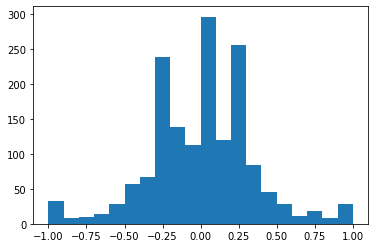

In [16]:
data_tuning = np.load("../input/data-tuning-2/data_tuning_2.npy", allow_pickle = True)
plt.hist(data_tuning[1], bins = 20)
print(len(data_tuning[0]))

In [17]:
Adagrad  = optimizers.Adagrad (learning_rate = 1e-5)
SGD      = optimizers.SGD     (learning_rate = 1e-5)
RMSprop  = optimizers.RMSprop (learning_rate = 1e-5)
Adadelta = optimizers.Adadelta(learning_rate = 1e-5)
Adam     = optimizers.Adam    (learning_rate = 1e-5)
Adamax   = optimizers.Adamax  (learning_rate = 1e-5)

In [18]:
optimizers  = [ Adagrad, SGD, RMSprop, Adadelta, Adam, Adamax]

name_op     = ['Adagrad', 'SGD', 'RMSprop', 'Adadelta', 'Adam', 'Adamax']
activations = ['elu', 'relu', 'tanh']

## 7.1 FT NVIDIA model

In [19]:
op            = []
count         = 0
batch_size    = 32

for i in optimizers:
    ac = []
    for j in activations:  
        count += 1
        print('Count:', count)
        print("Optimizer: ",i,"Activation:",j)
        model = nvidia_model(optimizer = i, activation = j)
        checkpoint_tuning_nvidia = ModelCheckpoint('checkpoint_tuning_nvidia.h5',  
                                                      verbose = 1,                                
                                                      mode    = 'auto',
                                                      monitor = 'val_loss',  
                                                      save_best_only = True)
        
        history = model.fit(x = data_tuning[0],  y = data_tuning[1], 
                            validation_data  = (data_tuning[2], data_tuning[3]),
                            steps_per_epoch  = len(data_tuning[0]) // batch_size,
                            epochs     = 100  , 
                            verbose    = 0   ,
                            callbacks  = [checkpoint_tuning_nvidia])
        m = min(history.history["val_loss"])
        print(m)
        ac.append(m)
    ac.append(activations[np.argmin(ac)])
    op.append(ac)

Count: 1
Optimizer:  <keras.optimizer_v2.adagrad.Adagrad object at 0x7f18680d5b50> Activation: elu


2022-11-08 13:13:59.324616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 13:13:59.325631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 13:13:59.502592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 13:13:59.503636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 13:13:59.504490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 13:13:59.507735: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 13:13:59.775388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 13:13:59.776625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 13:13:59.777517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

2022-11-08 13:14:03.753918: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 983040000 exceeds 10% of free system memory.
2022-11-08 13:14:04.885886: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 983040000 exceeds 10% of free system memory.


2022-11-08 13:14:05.712726: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2022-11-08 13:14:08.648322: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005



Epoch 00001: val_loss improved from inf to 0.08226, saving model to checkpoint_tuning_nvidia.h5



Epoch 00002: val_loss did not improve from 0.08226



Epoch 00003: val_loss did not improve from 0.08226



Epoch 00004: val_loss did not improve from 0.08226



Epoch 00005: val_loss did not improve from 0.08226



Epoch 00006: val_loss did not improve from 0.08226



Epoch 00007: val_loss did not improve from 0.08226



Epoch 00008: val_loss did not improve from 0.08226



Epoch 00009: val_loss did not improve from 0.08226



Epoch 00010: val_loss did not improve from 0.08226



Epoch 00011: val_loss did not improve from 0.08226



Epoch 00012: val_loss did not improve from 0.08226



Epoch 00013: val_loss did not improve from 0.08226



Epoch 00014: val_loss did not improve from 0.08226



Epoch 00015: val_loss did not improve from 0.08226



Epoch 00016: val_loss did not improve from 0.08226



Epoch 00017: val_loss did not improve from 0.08226



Epoch 00018: val_loss did not improve from 0.08226



Epoch 00019: val_loss did not improve from 0.08226



Epoch 00020: val_loss did not improve from 0.08226



Epoch 00021: val_loss did not improve from 0.08226



Epoch 00022: val_loss did not improve from 0.08226



Epoch 00023: val_loss did not improve from 0.08226



Epoch 00024: val_loss did not improve from 0.08226



Epoch 00025: val_loss did not improve from 0.08226



Epoch 00026: val_loss did not improve from 0.08226



Epoch 00027: val_loss did not improve from 0.08226



Epoch 00028: val_loss did not improve from 0.08226



Epoch 00029: val_loss did not improve from 0.08226



Epoch 00030: val_loss did not improve from 0.08226



Epoch 00031: val_loss did not improve from 0.08226



Epoch 00032: val_loss did not improve from 0.08226



Epoch 00033: val_loss did not improve from 0.08226



Epoch 00034: val_loss did not improve from 0.08226



Epoch 00035: val_loss did not improve from 0.08226



Epoch 00036: val_loss did not improve from 0.08226



Epoch 00037: val_loss did not improve from 0.08226



Epoch 00038: val_loss did not improve from 0.08226



Epoch 00039: val_loss did not improve from 0.08226



Epoch 00040: val_loss did not improve from 0.08226



Epoch 00041: val_loss did not improve from 0.08226



Epoch 00042: val_loss did not improve from 0.08226



Epoch 00043: val_loss did not improve from 0.08226



Epoch 00044: val_loss did not improve from 0.08226



Epoch 00045: val_loss did not improve from 0.08226



Epoch 00046: val_loss did not improve from 0.08226



Epoch 00047: val_loss did not improve from 0.08226



Epoch 00048: val_loss did not improve from 0.08226



Epoch 00049: val_loss did not improve from 0.08226


In [ ]:
table_nvidia = pd.DataFrame(np.array(op).T, columns = [ 'Adagrad', 'SGD', 'RMSprop', 'Adadelta', 'Adam', 'Adamax'])
d = []
for i in table_nvidia.values:
    d.append(name_op[i.argmin()])
d[-1] = 1
table_nvidia["Best Choice"] = d
table_nvidia.to_csv('Finetuning_nvidia.csv', index=False)
data_test_nvidia = pd.read_csv('Finetuning_nvidia.csv')
data_test_nvidia 

## 7.2 FT ResNet50 model

In [ ]:
op            = []
count         = 0
batch_size    = 32

for i in optimizers:
    ac = []
    for j in activations:  
        count += 1
        print('Count:', count)
        print("Optimizer: ",i,"Activation:",j)
        model = resnet50_model(optimizer = i, activation = j)
        checkpoint_tuning_nvidia = ModelCheckpoint('checkpoint_tuning_resnet50.h5',  
                                                      verbose = 1,                                
                                                      mode    = 'auto',
                                                      monitor = 'val_loss',  
                                                      save_best_only = True)
        
        history = model.fit(x = data_tuning[0],  y = data_tuning[1], 
                            validation_data  = (data_tuning[2], data_tuning[3]),
                            steps_per_epoch  = len(data_tuning[0]) // batch_size,
                            epochs     = 100  , 
                            verbose    = 0   ,
                            callbacks  = [checkpoint_tuning_nvidia])
        m = min(history.history["val_loss"])
        print(m)
        ac.append(m)
    ac.append(activations[np.argmin(ac)])
    op.append(ac)

In [ ]:
table_resnet50 = pd.DataFrame(np.array(op).T, columns = [ 'Adagrad', 'SGD', 'RMSprop', 'Adadelta', 'Adam', 'Adamax'])
d = []
for i in table_resnet50.values:
    d.append(name_op[i.argmin()])
d[-1] = 1
table_resnet50["Best Choice"] = d
table_resnet50.to_csv('Finetuning_resnet50.csv', index=False)
data_test_resnet50 = pd.read_csv('Finetuning_resnet50.csv')
data_test_resnet50 

## 7.3 FT Inception V3 model

In [ ]:
op            = []
count         = 0
batch_size    = 32

for i in optimizers:
    ac = []
    for j in activations:  
        count += 1
        print('Count:', count)
        print("Optimizer: ",i,"Activation:",j)
        model = inceptionv3_model(optimizer = i, activation = j)
        checkpoint_tuning_nvidia = ModelCheckpoint('checkpoint_tuning_inceptionv3.h5',  
                                                      verbose = 1,                                
                                                      mode    = 'auto',
                                                      monitor = 'val_loss',  
                                                      save_best_only = True)
        
        history = model.fit(x = data_tuning[0],  y = data_tuning[1], 
                            validation_data  = (data_tuning[2], data_tuning[3]),
                            steps_per_epoch  = len(data_tuning[0]) // batch_size,
                            epochs     = 100  , 
                            verbose    = 0   ,
                            callbacks  = [checkpoint_tuning_nvidia])
        m = min(history.history["val_loss"])
        print(m)
        ac.append(m)
    ac.append(activations[np.argmin(ac)])
    op.append(ac)

In [ ]:
table_inceptionv3 = pd.DataFrame(np.array(op).T, columns = ['RMSprop', 'Adam'])
d = []
for i in table_inceptionv3.values:
    d.append(name_op[i.argmin()])
d[-1] = 1
table_inceptionv3["Best Choice"] = d
table_inceptionv3.to_csv('Finetuning_inceptionv3.csv', index=False)
data_test_inceptionv3 = pd.read_csv('Finetuning_inceptionv3.csv')
data_test_inceptionv3

## 7.4 FT Results

### 7.4.1 FT NVIDIA model results

In [ ]:
data_test_nvidia = pd.read_csv('../input/results-finetuning/FT Results/Finetuning_nvidia.csv')
data_test_nvidia 

In [ ]:
data_test_nvidia_sub = pd.read_csv('../input/results-finetuning/FT Results/Finetuning_nvidia_sub.csv')
data_test_nvidia_sub

#### Choose **ADAM** and **RELU** for NVIDIA model

### 7.4.2 FT ResNet50 model results

In [ ]:
data_test_resnet50 = pd.read_csv('../input/results-finetuning/FT Results/Finetuning_resnet50.csv')
data_test_resnet50 

In [ ]:
data_test_resnet50_sub = pd.read_csv('../input/results-finetuning/FT Results/Finetuning_resnet50_sub.csv')
data_test_resnet50_sub 

#### Choose **SGD** and **ELU** for ResNet50 model

### 7.4.3 FT Inception V3 model results

In [ ]:
data_test_inceptionv3 = pd.read_csv('../input/results-finetuning/FT Results/Finetuning_inceptionv3.csv')
data_test_inceptionv3 

In [ ]:
data_test_inceptionv3_sub = pd.read_csv('../input/results-finetuning/FT Results/Finetuning_inceptionv3_sub.csv')
data_test_inceptionv3_sub

#### Choose **RMSPROP** and **ELU** for Inception v3 model

# 8. Training

## 8.1 Training NVIDIA model

In [ ]:
checkpoint_nvidia = ModelCheckpoint('checkpoint_nvidia.h5',  
                                      verbose = 1,                                
                                      mode    = 'auto',
                                      monitor = 'val_loss',  
                                      save_best_only = True)

model = nvidia_model(optimizer = Adam, activation = 'relu')

In [ ]:
history = model.fit(  train_generator, 
                      validation_data  = validation_generator,
                      steps_per_epoch  = len(train_samples)      // batch_size,
                      validation_steps = len(validation_samples) // batch_size,
                      epochs     = 200 , 
                      verbose    = 1   ,
                      callbacks  = [checkpoint_nvidia])

In [ ]:
history_loss = [history.history['loss'], history.history['val_loss']]
np.save("history loss nvidia.npy", history_loss)

## 8.2 Training ResNet50 model

In [ ]:
checkpoint_resnet50 = ModelCheckpoint('checkpoint_resnet50.h5',  
                                      verbose = 1,                                
                                      mode    = 'auto',
                                      monitor = 'val_loss',  
                                      save_best_only = True)

model_1 = resnet50_model(optimizer = SGD, activation = 'elu')

In [ ]:
history = model_1.fit(  train_generator, 
                      validation_data  = validation_generator,
                      steps_per_epoch  = len(train_samples)      // batch_size,
                      validation_steps = len(validation_samples) // batch_size,
                      epochs     = 200 , 
                      verbose    = 1   ,
                      callbacks  = [checkpoint_resnet50])

In [ ]:
history_loss = [history.history['loss'], history.history['val_loss']]
np.save("history_loss_1.npy", history_loss)

In [ ]:
SGD_2   = optimizers.SGD(learning_rate = 1e-4)
model_2 = resnet50_model(optimizer = SGD, activation = 'elu')

In [ ]:
history_loss = [history.history['loss'], history.history['val_loss']]
np.save("history_loss_2.npy", history_loss)

## 8.3 Training Inception V3 model

In [ ]:
checkpoint_inceptionv3 = ModelCheckpoint('checkpoint_inceptionv3.h5',  
                                      verbose = 1,                                
                                      mode    = 'auto',
                                      monitor = 'val_loss',  
                                      save_best_only = True)

model = inceptionv3_model(optimizer = RMSprop, activation = 'elu')

In [ ]:
history = model.fit(  train_generator, 
                      validation_data  = validation_generator,
                      steps_per_epoch  = len(train_samples)      // batch_size,
                      validation_steps = len(validation_samples) // batch_size,
                      epochs     = 200 , 
                      verbose    = 1   ,
                      callbacks  = [checkpoint_inceptionv3])

In [ ]:
history_loss = [history.history['loss'], history.history['val_loss']]
np.save("history_loss_2.npy", history_loss)

# 9. Results

## 9.1 NVIDIA model

In [ ]:
data_test_nvidia = np.load("../input/data-test/Data Test/data_test_nvidia.npy", allow_pickle = True)
history_loss_nvidia = np.load("../input/model-nividia/NVIDIA/history loss nvidia.npy", allow_pickle = True)

y_test_nvidia = data_test_nvidia[0]
y_pred_nvidia = data_test_nvidia[1]

train_loss_nvidia = min(history_loss_nvidia[0])
vali_loss_nvidia  = min(history_loss_nvidia[1])
test_loss_nvidia  = mean_squared_error(y_test_nvidia, y_pred_nvidia)

fig1 = plt.figure(figsize = (9,5.8))
plt.plot(history_loss_nvidia[0], color = 'red')
x = [0, 200]
y = [train_loss_nvidia, train_loss_nvidia]
plt.plot(x,y, color = 'red')

plt.plot(history_loss_nvidia[1], color = 'green')
y = [vali_loss_nvidia, vali_loss_nvidia]
plt.plot(x,y, color = 'green')
y = [test_loss_nvidia, test_loss_nvidia]
plt.plot(x,y, color = 'orange')

plt.title('Model NVIDIA loss with lr = 1e-5')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0, 0.5])
plt.legend(['Train\nLoss: '+str(round(train_loss_nvidia,5)), '', 'Validaion\nLoss: '+str(round(vali_loss_nvidia,5)), '', 'Test\nLoss: '+str(round(test_loss_nvidia,5))], loc='upper right')
plt.show()

## 9.2 ResNet50

In [ ]:
data_test_resnet50 = np.load("../input/data-test/Data Test/data_test_resnet50.npy", allow_pickle = True)
y_test_resnet50 = data_test_resnet50[0]
y_pred_resnet50 = data_test_resnet50[1]
test_loss_resnet50  = mean_squared_error(y_test_resnet50, y_pred_resnet50)
fig1 = plt.figure(figsize = (20,6))

plt.subplot(1, 2, 1)
history_loss_resnet50_1 = np.load("../input/model-resnet/ResNet50/history_loss_1.npy", allow_pickle = True)
train_loss_resnet50_1 = min(history_loss_resnet50_1[0])
vali_loss_resnet50_1  = min(history_loss_resnet50_1[1])

plt.plot(history_loss_resnet50_1[0], color = 'red')
x = [0, 200]
y = [train_loss_resnet50_1, train_loss_resnet50_1]
plt.plot(x,y, color = 'red')

plt.plot(history_loss_resnet50_1[1], color = 'green')
y = [vali_loss_resnet50_1, vali_loss_resnet50_1]
plt.plot(x,y, color = 'green')
y = [test_loss_resnet50, test_loss_resnet50]
plt.plot(x,y, color = 'orange')

plt.title('Model ResNet50 loss with lr = 1e-5')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0, 0.5])
plt.legend(['Train\nLoss: '+str(round(train_loss_resnet50_1,5)), '', 'Validaion\nLoss: '+str(round(vali_loss_resnet50_1,5)), '', 'Test\nLoss: '+str(round(test_loss_resnet50,5))], loc='upper right')


plt.subplot(1, 2, 2)
history_loss_resnet50_2 = np.load("../input/model-resnet/ResNet50/history_loss_2.npy", allow_pickle = True)
train_loss_resnet50_2 = min(history_loss_resnet50_2[0])
vali_loss_resnet50_2  = min(history_loss_resnet50_2[1])

plt.plot(history_loss_resnet50_2[0], color = 'red')
x = [0, 200]
y = [train_loss_resnet50_2, train_loss_resnet50_2]
plt.plot(x,y, color = 'red')

plt.plot(history_loss_resnet50_2[1], color = 'green')
y = [vali_loss_resnet50_2, vali_loss_resnet50_2]
plt.plot(x,y, color = 'green')
y = [test_loss_resnet50, test_loss_resnet50]
plt.plot(x,y, color = 'orange')

plt.title('Model ResNet50 loss with lr = 1e-4')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0, 0.5])
plt.legend(['Train\nLoss: '+str(round(train_loss_resnet50_2,5)), '', 'Validaion\nLoss: '+str(round(vali_loss_resnet50_2,5)), '', 'Test\nLoss: '+str(round(test_loss_resnet50,5))], loc='upper right')
plt.show()

## 9.3 Inception V3

In [ ]:
data_test_inceptionv3 = np.load("../input/data-test/Data Test/data_test_inceptionv3.npy", allow_pickle = True)
history_loss_inceptionv3 = np.load("../input/model-inceptionv3/Inception v3/history_loss_2.npy", allow_pickle = True)

y_test_inceptionv3 = data_test_inceptionv3[0]
y_pred_inceptionv3 = data_test_inceptionv3[1]

train_loss_inceptionv3 = min(history_loss_inceptionv3[0])
vali_loss_inceptionv3  = min(history_loss_inceptionv3[1])
test_loss_inceptionv3  = mean_squared_error(y_test_inceptionv3, y_pred_inceptionv3)

fig1 = plt.figure(figsize = (9,5.8))
plt.plot(history_loss_inceptionv3[0], color = 'red')
x = [0, 200]
y = [train_loss_inceptionv3, train_loss_inceptionv3]
plt.plot(x,y, color = 'red')

plt.plot(history_loss_inceptionv3[1], color = 'green')
y = [vali_loss_inceptionv3, vali_loss_inceptionv3]
plt.plot(x,y, color = 'green')
y = [test_loss_inceptionv3, test_loss_inceptionv3]
plt.plot(x,y, color = 'orange')

plt.title('Model Inception V3 loss with lr = 1e-5')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0, 0.5])
plt.legend(['Train\nLoss: '+str(round(train_loss_inceptionv3,5)), '', 'Validaion\nLoss: '+str(round(vali_loss_inceptionv3,5)), '', 'Test\nLoss: '+str(round(test_loss_inceptionv3,5))], loc='upper right')
plt.show()

## 9.4 Summary results

In [ ]:
nvidia    = [train_loss_nvidia, vali_loss_nvidia, test_loss_nvidia]
resnet    = [train_loss_resnet50_2, vali_loss_resnet50_2, test_loss_resnet50]
inception = [train_loss_inceptionv3, vali_loss_inceptionv3, test_loss_inceptionv3]
index = ['Train', 'Validation', 'Test']
df = pd.DataFrame({'NVIDIA': nvidia,
                   'Inception V3': inception,
                   'ResNet50': resnet}, index=index)
ax = df.plot.bar(rot=0, figsize = (9,5.8))